In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset


c:\Users\usuario\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Import 
data1 = pd.read_csv('./data/train.csv')
data2 = pd.read_csv('./data/test.csv')

# Preprocess
terrorism = pd.concat([data1, data2], axis=0, ignore_index=True)
terrorism = terrorism[[' "tweet"', 'class']]
terrorism.rename(columns={' "tweet"': 'tweet'}, inplace=True)

In [4]:
def preprocess(data, col1, num_class):
    data = data[[col1]].copy()
    data['class'] = num_class
    data.rename(columns={col1: 'tweet'}, inplace=True)
    return data

# Import
data3 = pd.read_csv('./data/ISIS Religious Texts v1.csv', encoding='cp1252')
data4 = pd.read_csv('./data/indonesian_tweet_about_teroris.csv', encoding='utf8')

# Preprocess
data3 = preprocess(data3, 'Quote', 1)
data4 = preprocess(data4, 'tweet text', 1)

In [5]:
# Concat all dataframe
df = pd.concat([terrorism, data3, data4], axis=0, ignore_index=True)

In [6]:
required_tweets = abs(df['class'].value_counts()[0] - df['class'].value_counts()[1])

In [7]:
header = ["target", "ids", "date", "flag", "user", "text"]
data5 = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding='cp1252', names=header)
data5 = preprocess(data5, 'text', 0)
data5 = data5.sample(n=required_tweets, random_state=42)

In [8]:
# Concat all dataframe
df = pd.concat([df, data5], axis=0, ignore_index=True)

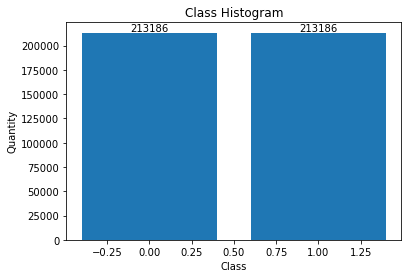

In [9]:
# Count the quantity of each class
class_count = df['class'].value_counts()

# Create a histogram
plt.bar(class_count.index, class_count.values)

# Add labels on the bars with values
for i, v in enumerate(class_count.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Quantity')
plt.title('Class Histogram')

# Show the histogram
plt.show()


In [15]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [33]:
# Tokenizar los textos con el tokenizer de mBERT
def tokenize_texts(texts, tokenizer, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
    return encodings

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Obtener los textos y las etiquetas de entrenamiento y prueba
train_texts = train_data["tweet"].astype(str).tolist()
train_labels = torch.tensor(train_data["class"].tolist())

test_texts = test_data["tweet"].astype(str).tolist()
test_labels = torch.tensor(test_data["class"].tolist())

# Tokenizar los textos
train_encodings = tokenize_texts(train_texts, tokenizer)
test_encodings = tokenize_texts(test_texts, tokenizer)

# Crear conjuntos de datos y dataloaders
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels)

batch_size = 32  # Puedes ajustar el tamaño del lote según tus necesidades

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [34]:
# Cargar el modelo preentrenado de mBERT para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

# Optimizador
optimizer = AdamW(model.parameters(), lr=2e-5)

# Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(2):  # Número de épocas
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluación
model.eval()
total_accuracy = 0.0
total_count = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = torch.sum(predictions == labels).item()
        total_accuracy += accuracy
        total_count += len(labels)

accuracy = total_accuracy / total_count
print(f"Accuracy on Test Set: {accuracy:.2f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\usuario\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [125]:
# Tokenizar los textos con el tokenizer de mBERT
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

train_texts = train_data["tweet"].tolist()
test_texts = test_data["tweet"].tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt", max_length=128)

# Crear conjuntos de datos y dataloaders
train_labels = torch.tensor(train_data["class"].tolist())
test_labels = torch.tensor(test_data["class"].tolist())

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels)
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Cargar el modelo preentrenado de mBERT para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

# Optimizador
optimizer = AdamW(model.parameters(), lr=2e-5)

# Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(2):  # Número de épocas
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluación
model.eval()
total_accuracy = 0.0
total_count = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = torch.sum(predictions == labels).item()
        total_accuracy += accuracy
        total_count += len(labels)

accuracy = total_accuracy / total_count
print(f"Accuracy on Test Set: {accuracy:.2f}")

ValueError: Input is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.